In [1]:
import SimpleITK as sitk
import vtk
import numpy as np
from vtk.util import numpy_support
import os
import matplotlib.pyplot as plt

In [2]:
MRI_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/MRI'
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
CT_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/CT'

mri_dir = sorted(os.listdir(MRI_PATH), key = lambda x: x)
sct_dir = sorted([file for file in os.listdir(SCT_PATH) if file[-6:]=='nii.gz'], key = lambda x: x)
ct_dir = sorted([file for file in os.listdir(CT_PATH) if file[-6:]=='nii.gz'], key = lambda x: x)

In [2]:
def visualize_vtk_mesh(mesh):
    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(mesh)

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.1, 0.2, 0.4)  # Background color

    # Create a render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)  # Window size

    # Create an interactor
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)

    # Start the visualization
    interactor.Initialize()
    render_window.Render()
    interactor.Start()

def visualize_vtk_image_data(image_data):
    # Create a mapper for the slice
    slice_mapper = vtk.vtkImageResliceMapper()
    slice_mapper.SetInputData(image_data)
    slice_mapper.SliceAtFocalPointOn()

    # Create a slice actor
    slice_actor = vtk.vtkImageSlice()
    slice_actor.SetMapper(slice_mapper)

    # Create a renderer and add the slice actor
    renderer = vtk.vtkRenderer()
    renderer.AddActor(slice_actor)
    renderer.SetBackground(0.1, 0.2, 0.4)  # Background color

    # Create a render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)  # Window size

    # Create an interactor
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)

    # Set up the slice interactor style
    style = vtk.vtkInteractorStyleImage()
    interactor.SetInteractorStyle(style)

    # Start the visualization
    interactor.Initialize()
    render_window.Render()
    interactor.Start()

In [3]:
def sitk_to_vtk(image_sitk):
    np_array = sitk.GetArrayFromImage(image_sitk)  # Shape: (z, y, x)

    # Convert numpy array to VTK-compatible order (x, y, z)
    np_array = np.transpose(np_array, (2, 1, 0))  # Now shape: (x, y, z)

    # Create VTK image and set metadata
    vtk_image = vtk.vtkImageData()
    vtk_image.SetDimensions(*np_array.shape)
    vtk_image.SetSpacing(image_sitk.GetSpacing())
    vtk_image.SetOrigin(image_sitk.GetOrigin())

    # Copy numpy array to VTK
    vtk_array = numpy_support.numpy_to_vtk(np_array.ravel(order="F"), deep=True, array_type=vtk.VTK_FLOAT)
    vtk_image.GetPointData().SetScalars(vtk_array)
    return vtk_image

In [7]:
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
sct_dir = [file for file in os.listdir(SCT_PATH) if file[-6:]=='nii.gz']
CT_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/CT'
image_sitk = sitk.ReadImage(SCT_PATH + '/' + sct_dir[1])

In [24]:
threshold_value=400    
vtk_image = sitk_to_vtk(image_sitk)

# Threshold to isolate the skull (adjust value based on your data)
threshold = vtk.vtkImageThreshold()
threshold.SetInputData(vtk_image)
threshold.ThresholdByUpper(threshold_value)
threshold.ReplaceInOn()
threshold.SetInValue(1)
threshold.ReplaceOutOn()
threshold.SetOutValue(0)
threshold.Update()

# Keep only the largest connected component
connectivity = vtk.vtkImageConnectivityFilter()
connectivity.SetInputConnection(threshold.GetOutputPort())
connectivity.SetExtractionModeToLargestRegion()
connectivity.Update()

# Generate mesh using Marching Cubes
surface = vtk.vtkMarchingCubes()
surface.SetInputData(connectivity.GetOutput())
surface.SetInputData(threshold.GetOutput())
surface.SetValue(0, 0.5)  # Midpoint between 0 (background) and 1 (skull)
surface.Update()

# Simplify the mesh (optional)
decimate = vtk.vtkDecimatePro()
decimate.SetInputData(surface.GetOutput())
decimate.SetTargetReduction(0.2) # Reduce polygon count by 20%
decimate.Update()

# Smooth the mesh (optional)
smoother = vtk.vtkWindowedSincPolyDataFilter()
smoother.SetInputConnection(decimate.GetOutputPort())
smoother.SetNumberOfIterations(15)
smoother.Update()


In [71]:
# output_mesh = "cleaned_skull.obj"
# # Write the cleaned mesh to OBJ
# writer = vtk.vtkOBJWriter()
# writer.SetFileName(output_mesh)
# writer.SetInputConnection(smoother.GetOutputPort())
# writer.Write()

In [27]:
visualize_vtk_mesh(smoother.GetOutput())

In [26]:
# visualize_vtk_image_data(vtk_image)
visualize_vtk_image_data(threshold.GetOutput())

In [4]:
def visualize_ct(vtk_image):
    # Create a GPU-based volume mapper.
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(vtk_image)

    # Define a color transfer function.
    # Adjust these points as needed for your CT image intensity range.
    volumeColor = vtk.vtkColorTransferFunction()
    # volumeColor.AddRGBPoint(-1000, 0.0, 0.0, 0.0)  # air (black)
    # volumeColor.AddRGBPoint(0,     1.0, 1.0, 1.0)  # soft tissue (white)
    # volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)  # bone (white)
    volumeColor.AddRGBPoint(0,     0.0, 0.0, 0.0)  # Background (black)
    volumeColor.AddRGBPoint(200,   0.8, 0.8, 0.8)  # Lower bone intensity (light gray)
    volumeColor.AddRGBPoint(1000,  1.0, 1.0, 0.9)  # Higher bone intensity (bright white with a hint of yellow)
    volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)

    # Define an opacity (scalar) transfer function.
    volumeOpacity = vtk.vtkPiecewiseFunction()
    # volumeOpacity.AddPoint(-1000, 0.0)
    # volumeOpacity.AddPoint(0,     0.1)
    # volumeOpacity.AddPoint(3000,  0.9)
    volumeOpacity.AddPoint(0,     0.0)    # Fully transparent for background
    volumeOpacity.AddPoint(200,   0.1)    # Start showing bone
    volumeOpacity.AddPoint(1000,  0.8)    # High opacity for bone
    volumeOpacity.AddPoint(3000,  1.0)    # Maximum opacity for dense bone

    # Set up the volume properties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # Create the volume actor.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # --- Create the rendering window, renderer, and interactor ---
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    renderer.SetBackground(0.1, 0.1, 0.1)  # dark gray background

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    # Start the visualization.
    interactor.Initialize()
    renderWindow.Render()
    interactor.Start()


In [25]:
vtk_image = sitk_to_vtk(image_sitk)
visualize_ct(vtk_image)

In [5]:
def remove_artifacts_sitk(image_sitk, threshold=400):
    # Step 1: Thresholding to create a binary mask
    binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=threshold, upperThreshold=3000)

    # Step 2: Connected component analysis
    connected_components = sitk.ConnectedComponent(binary_mask)
    
    # Step 3: Relabel components by size (biggest component is the skull)
    labeled_components = sitk.RelabelComponent(connected_components, sortByObjectSize=True)

    # Step 4: Keep only the largest component (skull)
    skull_mask = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
    # background_mask = sitk.BinaryNot(skull_mask)

    # Step 5: Apply mask to original image  
    skull_image = sitk.Mask(image_sitk, skull_mask)
    # background_image = sitk.Mask(image_sitk, background_mask)

    # result_image = sitk.Add(skull_image, background_image)
    return skull_image
    # return result_image

In [10]:
image_sitk = sitk.ReadImage(CT_PATH + '/' + os.listdir(CT_PATH)[0])

In [11]:
sitk_artifact_removed = remove_artifacts_sitk(image_sitk)
vtk_artifact_removed = sitk_to_vtk(sitk_artifact_removed)
visualize_ct(vtk_artifact_removed)

In [78]:
np.histogram(sitk.GetArrayFromImage(sitk_artifact_removed).flatten()), np.histogram(sitk.GetArrayFromImage(image_sitk).flatten())

((array([9664790,   78198,  130133,  145771,  108839,   17030,    1498,
            1149,    1376,    1083]),
  array([   0.     ,  297.4119 ,  594.8238 ,  892.23566, 1189.6476 ,
         1487.0594 , 1784.4713 , 2081.8833 , 2379.2952 , 2676.707  ,
         2974.119  ], dtype=float32)),
 (array([6129331,  208352, 3217240,  179863,  176683,  187543,   45675,
            1897,    1647,    1636]),
  array([-1024.     ,  -624.1881 ,  -224.37622,   175.43567,   575.24756,
           975.05945,  1374.8713 ,  1774.6832 ,  2174.495  ,  2574.3071 ,
          2974.119  ], dtype=float32)))

### Visualize the created obj files

In [29]:
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
mesh_paths = sorted([file for file in os.listdir(SCT_PATH) if file[-3:]=='obj'])

In [44]:
import vtk

def visualize_obj_file(obj_file_path):
    # Read the OBJ file
    reader = vtk.vtkOBJReader()
    reader.SetFileName(obj_file_path)
    reader.Update()

    # Get the mesh data
    mesh = reader.GetOutput()

    # Check if the mesh is valid
    if mesh.GetNumberOfPoints() == 0:
        raise ValueError("The OBJ file contains no data or could not be read.")

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(mesh)

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.1, 0.1, 0.1)  # Dark gray background

    # Create a render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)

    # Create an interactor
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)

    # Initialize and start the visualization
    interactor.Initialize()
    render_window.Render()
    interactor.Start()

In [48]:
idx = 0
print(mesh_paths[idx])
visualize_obj_file(os.path.join(SCT_PATH, mesh_paths[idx]))
# visualize_obj(os.path.join(SCT_PATH, mesh_paths[idx]))

1BA075_sct.obj


In [46]:
import vtk

def visualize_obj(obj_file_path, output_image_path=None):
    # --- Replace CT reader with OBJ reader ---
    reader = vtk.vtkOBJReader()
    reader.SetFileName(obj_file_path)  # Replace with your OBJ file path
    reader.Update()
    mesh = reader.GetOutput()

    # --- Create a GPU-based volume mapper ---
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(mesh)

    # The rest of your code (clipping, color transfer function, renderer setup, etc.) remains unchanged.
    # For example, your existing clipping code:
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = mesh.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1])/2,
                             (bounds[2] + bounds[3])/2,
                             (bounds[4] + bounds[5])/2)
    volumeMapper.AddClippingPlane(clipping_plane)

    # (The remainder of your visualization pipeline—setting up the color transfer function,
    # opacity, volume property, renderer, camera, image capture, etc.—stays the same.)
    
    # --- Create the volume property (using your existing color and opacity transfer functions) ---
    volumeColor = vtk.vtkColorTransferFunction()
    volumeColor.AddRGBPoint(0,     0.0, 0.0, 0.0)
    volumeColor.AddRGBPoint(200,   0.8, 0.8, 0.8)
    volumeColor.AddRGBPoint(1000,  1.0, 1.0, 0.9)
    volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)

    volumeOpacity = vtk.vtkPiecewiseFunction()
    volumeOpacity.AddPoint(0,     0.0)
    volumeOpacity.AddPoint(200,   0.1)
    volumeOpacity.AddPoint(1000,  0.8)
    volumeOpacity.AddPoint(3000,  1.0)

    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # --- Create the volume actor ---
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # --- Set up the renderer, render window, and interactor ---
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    renderer.SetBackground(1, 1, 1)  # white background

    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()
    center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])
    camera.SetFocalPoint(center)
    camera.SetViewUp(0, 0, 1)  # Z-axis as up

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    renderWindow.Render()

    # --- Save the rendered view to a PNG file ---
    window_to_image = vtk.vtkWindowToImageFilter()
    window_to_image.SetInput(renderWindow)
    window_to_image.SetScale(1)
    window_to_image.SetInputBufferTypeToRGB()
    window_to_image.ReadFrontBufferOff()
    window_to_image.Update()

    # writer = vtk.vtkPNGWriter()
    # writer.SetFileName(output_image_path)
    # writer.SetInputConnection(window_to_image.GetOutputPort())
    # writer.Write()

    interactor.Initialize()
    interactor.Start()



### Comparison

In [2]:
import os
import SimpleITK as sitk
from segmentation_functions import segmentation_stats
import numpy as np
import vtk
import tqdm
import pandas as pd

In [3]:
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
CT_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/CT'
sct_dir = sorted([file for file in os.listdir(SCT_PATH) if file[-6:]=='nii.gz'], key = lambda x: x)
ct_dir = sorted(os.listdir(CT_PATH), key = lambda x: x)
ct_full_dir = [os.path.join(CT_PATH, ct_dir[idx]) for idx in range(len(ct_dir))]
sct_full_dir = [os.path.join(SCT_PATH, sct_dir[idx]) for idx in range(len(sct_dir))]

In [4]:
def load_and_threshold(image_path, threshold=400):
    image = sitk.ReadImage(image_path, sitk.sitkInt16)
    binary_image = sitk.BinaryThreshold(image,
                                        lowerThreshold=threshold,
                                        upperThreshold=3000,
                                        insideValue=1,
                                        outsideValue=0)
    return binary_image

def get_file_name(dir):
    return dir.split('/')[-1].split('.')[0]

In [ ]:
for ref_dir, seg_dir in zip(ct_full_dir, sct_full_dir):
    ref = load_and_threshold(ref_dir)
    seg = load_and_threshold(seg_dir)
    file_id = get_file_name(ref_dir)
    print(file_id)
    one_row = segmentation_stats(ref, seg, ct_dir[0])
    if 'df' not in locals():
        df = one_row
    else:
        df = pd.concat([df, one_row], ignore_index=True, sort=False)
df.to_csv('/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/comparison/skull_metrics.csv', index=False)

In [5]:
idx = 0

ref = load_and_threshold(os.path.join(CT_PATH, ct_dir[idx]))
seg = load_and_threshold(os.path.join(SCT_PATH, sct_dir[idx]))
id_file = ct_dir[idx]
print(ct_dir[idx],sct_dir[idx])

1BA075_ct.nii.gz 1BA075_sct.nii.gz


In [6]:
one_row = segmentation_stats(ref, seg, ct_dir[0])

In [8]:
df = pd.concat([one_row, one_row], sort=False)

In [9]:
df

,DICE,FALSE NEGATIVE,FALSE POSITIVE,HAUSDORFF,JACCARD,MAX SURFACE DISTANCE,MEAN SURFACE DISTANCE,MEDIAN SURFACE DISTANCE,MIN SURFACE DISTANCE,P99 SURFACE DISTANCE,Q1 SURFACE DISTANCE,Q3 SURFACE DISTANCE,STD SURFACE DISTANCE,VOLUME SIMILARITY
1BA075_ct.nii.gz,0.91121,0.083681,0.005238,48.887626,0.836902,48.887627,0.384527,0.0,0.0,5.09902,0.0,0.0,1.300118,0.011151
1BA075_ct.nii.gz,0.91121,0.083681,0.005238,48.887626,0.836902,48.887627,0.384527,0.0,0.0,5.09902,0.0,0.0,1.300118,0.011151


## MRI

In [12]:
MRI_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/MRI'
CT_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/CT'
# SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/25_02_18_artifact/infer'
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
mri_dir = sorted(os.listdir(MRI_PATH), key = lambda x: x)
sct_dir = sorted([file for file in os.listdir(SCT_PATH) if file[-6:]=='nii.gz'], key = lambda x: x)
ct_dir = sorted(os.listdir(CT_PATH), key = lambda x: x)
# ct_full_dir = [os.path.join(CT_PATH, ct_dir[idx]) for idx in range(len(ct_dir))]
# sct_full_dir = [os.path.join(SCT_PATH, sct_dir[idx]) for idx in range(len(sct_dir))]

In [20]:
sct_dir[0]

'1BA075_sct.nii.gz'

In [23]:
idx = 1
output_dir = SCT_PATH[:-5] + 'comparison/' + sct_dir[idx][:-7] + '.png'
visualize_ct(os.path.join(SCT_PATH, sct_dir[1]), output_dir)

In [24]:
idx = 1
output_dir = SCT_PATH[:-5] + 'comparison/' + ct_dir[idx][:-7] + '.png'
visualize_ct(os.path.join(CT_PATH, ct_dir[1]), output_dir)

In [18]:
import vtk
from vtk.util import numpy_support

# Load the 3D MRI image (replace 'path_to_your_image.nii' with your actual file path)
reader = vtk.vtkNIFTIImageReader()
reader.SetFileName(os.path.join(MRI_PATH, mri_dir[0]))
reader.Update()

# Get the image data
image_data = reader.GetOutput()

# Create a mapper
mapper = vtk.vtkGPUVolumeRayCastMapper()
mapper.SetInputData(image_data)

# Create a volume property
volume_property = vtk.vtkVolumeProperty()
volume_property.ShadeOn()
volume_property.SetInterpolationTypeToLinear()

# Define opacity and color transfer functions
opacity_transfer_function = vtk.vtkPiecewiseFunction()
opacity_transfer_function.AddPoint(0, 0.0)
opacity_transfer_function.AddPoint(500, 0.1)
opacity_transfer_function.AddPoint(1000, 0.5)
opacity_transfer_function.AddPoint(1500, 1.0)

color_transfer_function = vtk.vtkColorTransferFunction()
color_transfer_function.AddRGBPoint(0, 0.0, 0.0, 0.0)
color_transfer_function.AddRGBPoint(500, 0.5, 0.5, 0.5)
color_transfer_function.AddRGBPoint(1000, 1.0, 1.0, 1.0)
color_transfer_function.AddRGBPoint(1500, 1.0, 1.0, 1.0)

volume_property.SetColor(color_transfer_function)
volume_property.SetScalarOpacity(opacity_transfer_function)

# Create the volume
volume = vtk.vtkVolume()
volume.SetMapper(mapper)
volume.SetProperty(volume_property)

# Create a renderer and add the volume to it
renderer = vtk.vtkRenderer()
renderer.AddVolume(volume)
renderer.SetBackground(0.1, 0.2, 0.4)

# Create a render window
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 600)

# Create an interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Initialize the interactor and start the rendering loop
interactor.Initialize()
render_window.Render()
interactor.Start()

In [33]:
import vtk
from vtk.util import numpy_support

# Load the 3D MRI image (replace 'path_to_your_image.nii' with your file path)
reader = vtk.vtkNIFTIImageReader()
reader.SetFileName(os.path.join(CT_PATH, ct_dir[15]))
# reader.SetFileName(os.path.join(MRI_PATH, mri_dir[15]))
reader.Update()

# Get the image data
image_data = reader.GetOutput()

# Create a volume mapper
volume_mapper = vtk.vtkGPUVolumeRayCastMapper()
volume_mapper.SetInputData(image_data)

# Define a clipping plane to cut the volume in half
clipping_plane = vtk.vtkPlane()
bounds = image_data.GetBounds()  # Get the bounds of the volume [x_min, x_max, y_min, y_max, z_min, z_max]

# Set the clipping plane to split along the sagittal plane (left-right)
# For coronal (front-back) or axial (top-bottom) cuts, adjust the normal and origin below.
clipping_plane.SetNormal(1, 0, 0)  # Normal along the x-axis (sagittal plane)
clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)  # Center of the volume

# Add the clipping plane to the mapper
volume_mapper.AddClippingPlane(clipping_plane)

# Configure transfer functions for better visibility of internal structures
color_transfer_function = vtk.vtkColorTransferFunction()
color_transfer_function.AddRGBPoint(0,   0.0, 0.0, 0.0)  # Black for background
color_transfer_function.AddRGBPoint(500, 1.0, 1.0, 1.0)  # Bone-like color
# color_transfer_function.AddRGBPoint(500, 0.7, 0.5, 0.3)  # Bone-like color
color_transfer_function.AddRGBPoint(1200, 1.0, 1.0, 1.0)  # White for dense structures

opacity_transfer_function = vtk.vtkPiecewiseFunction()
opacity_transfer_function.AddPoint(0,   0.0)  # Transparent background
opacity_transfer_function.AddPoint(500, 0.2)  # Semi-transparent for soft tissues
opacity_transfer_function.AddPoint(1200, 1.0)  # Opaque for bone

# Configure volume properties
volume_property = vtk.vtkVolumeProperty()
volume_property.SetColor(color_transfer_function)
volume_property.SetScalarOpacity(opacity_transfer_function)
volume_property.ShadeOn()
volume_property.SetInterpolationTypeToLinear()

# Create the volume and link the mapper/property
volume = vtk.vtkVolume()
volume.SetMapper(volume_mapper)
volume.SetProperty(volume_property)

# Renderer, window, and interactor
renderer = vtk.vtkRenderer()
renderer.AddVolume(volume)
renderer.SetBackground(0.1, 0.2, 0.4)  # Dark blue background

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 600)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Start the visualization
interactor.Initialize()
render_window.Render()
interactor.Start()

## Better Visualization

In [35]:
import vtk
from vtk.util import numpy_support

# Load the MRI image
reader = vtk.vtkNIFTIImageReader()
# reader.SetFileName(os.path.join(CT_PATH, ct_dir[15]))  # Replace with your file path
reader.SetFileName(os.path.join(MRI_PATH, mri_dir[15]))  # Replace with your file path
reader.Update()
image_data = reader.GetOutput()

# Create volume mapper with clipping plane
volume_mapper = vtk.vtkGPUVolumeRayCastMapper()
volume_mapper.SetInputData(image_data)

# Sagittal plane clipping (cut along left-right axis)
clipping_plane = vtk.vtkPlane()
clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
bounds = image_data.GetBounds()
clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)
volume_mapper.AddClippingPlane(clipping_plane)

# Transfer functions for contrast against white background
color_transfer = vtk.vtkColorTransferFunction()
color_transfer.AddRGBPoint(0,    0.2, 0.2, 0.2)   # Dark gray (background)
color_transfer.AddRGBPoint(400,  0.8, 0.4, 0.1)   # Orange (soft tissues)
color_transfer.AddRGBPoint(1000, 0.9, 0.7, 0.2)   # Gold (bone)
color_transfer.AddRGBPoint(1500, 0.3, 0.3, 0.7)   # Blue (dense structures)

opacity_transfer = vtk.vtkPiecewiseFunction()
opacity_transfer.AddPoint(0,    0.0)
opacity_transfer.AddPoint(400,  0.3)  # Semi-transparent for tissues
opacity_transfer.AddPoint(1000, 0.8)  # Mostly opaque for bone
opacity_transfer.AddPoint(1500, 1.0)

# Volume properties
volume_property = vtk.vtkVolumeProperty()
volume_property.SetColor(color_transfer)
volume_property.SetScalarOpacity(opacity_transfer)
volume_property.ShadeOn()
volume_property.SetInterpolationTypeToLinear()

# Create volume
volume = vtk.vtkVolume()
volume.SetMapper(volume_mapper)
volume.SetProperty(volume_property)

# Renderer setup with white background
renderer = vtk.vtkRenderer()
renderer.AddVolume(volume)
renderer.SetBackground(1, 1, 1)  # White background

# Set camera for 45-degree view of the half-face and interior
renderer.ResetCamera()
camera = renderer.GetActiveCamera()

# Position camera diagonally for angled view
center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
camera.SetPosition(center[0] + 300, center[1] - 250, center[2] + 200)  # Adjust offsets as needed
camera.SetFocalPoint(center[0], center[1], center[2])
camera.SetViewUp(0, 0, 1)  # Z-axis as up

# Render window and interactor
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(1200, 900)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Start visualization
interactor.Initialize()
render_window.Render()
interactor.Start()

In [3]:
def visualize_ct(ct_path, output_image_path):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(ct_path)  # Replace with your file path
    # reader.SetFileName(os.path.join(MRI_PATH, mri_dir[15]))  # Replace with your file path
    reader.Update()
    image_data = reader.GetOutput()

    # Create a GPU-based volume mapper.
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(image_data)

    # Sagittal plane clipping (cut along left-right axis)
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = image_data.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)
    volumeMapper.AddClippingPlane(clipping_plane)

    # Define a color transfer function.
    # Adjust these points as needed for your CT image intensity range.
    volumeColor = vtk.vtkColorTransferFunction()
    # volumeColor.AddRGBPoint(-1000, 0.0, 0.0, 0.0)  # air (black)
    # volumeColor.AddRGBPoint(0,     1.0, 1.0, 1.0)  # soft tissue (white)
    # volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)  # bone (white)
    volumeColor.AddRGBPoint(0,     0.0, 0.0, 0.0)  # Background (black)
    volumeColor.AddRGBPoint(200,   0.8, 0.8, 0.8)  # Lower bone intensity (light gray)
    volumeColor.AddRGBPoint(1000,  1.0, 1.0, 0.9)  # Higher bone intensity (bright white with a hint of yellow)
    volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)

    # Define an opacity (scalar) transfer function.
    volumeOpacity = vtk.vtkPiecewiseFunction()
    # volumeOpacity.AddPoint(-1000, 0.0)
    # volumeOpacity.AddPoint(0,     0.1)
    # volumeOpacity.AddPoint(3000,  0.9)
    volumeOpacity.AddPoint(0,     0.0)    # Fully transparent for background
    volumeOpacity.AddPoint(200,   0.1)    # Start showing bone
    volumeOpacity.AddPoint(1000,  0.8)    # High opacity for bone
    volumeOpacity.AddPoint(3000,  1.0)    # Maximum opacity for dense bone

    # Set up the volume properties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # Create the volume actor.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # --- Create the rendering window, renderer, and interactor ---
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    # renderer.SetBackground(0.1, 0.1, 0.1)  # dark gray background
    renderer.SetBackground(1, 1, 1)  # white background

    # Set camera for 45-degree view of the half-face and interior
    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()

    # Position camera diagonally for angled view
    center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
    # camera.SetPosition(center[0] + 300, center[1] - 250, center[2] + 200)  # Adjust offsets as needed
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])  # Adjust offsets as needed
    camera.SetFocalPoint(center[0], center[1], center[2])
    camera.SetViewUp(0, 0, 1)  # Z-axis as up

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    # Start the visualization.
    renderWindow.Render()

    # --- Save the rendered view to a PNG file ---
    # Create a filter to capture the window contents
    window_to_image = vtk.vtkWindowToImageFilter()
    window_to_image.SetInput(renderWindow)
    window_to_image.SetScale(1)  # Maintain original resolution
    window_to_image.SetInputBufferTypeToRGB()  # Capture color buffer
    window_to_image.ReadFrontBufferOff()  # Use back buffer (avoids blank image)
    window_to_image.Update()

    # Write the image to a file
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image_path)
    writer.SetInputConnection(window_to_image.GetOutputPort())
    writer.Write()

    interactor.Initialize()
    interactor.Render()
    interactor.Start()


In [11]:
output_dir = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/25_02_18_artifact/infer/comparison/vtk_test.png'
visualize_ct(os.path.join(CT_PATH, ct_dir[1]), output_dir)
# visualize_ct(os.path.join(MRI_PATH, mri_dir[15]), output_dir)

2025-02-20 15:50:01.836 ( 297.143s) [    7F7E0BE9C740]       vtkPNGWriter.cxx:246    ERR| vtkPNGWriter (0xc0a6e20): Unable to open file /home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/25_02_18_artifact/infer/comparison/vtk_test.png


In [7]:
def visualize_mri(mri_path, output_image_path):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(mri_path)
    reader.Update()
    image_data = reader.GetOutput()

    # Get the scalar range of the MRI data
    scalar_range = image_data.GetScalarRange()
    min_val = scalar_range[0]
    max_val = scalar_range[1]
    value_range = max_val - min_val

    # Create a GPU-based volume mapper
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(image_data)

    # Sagittal plane clipping (cut along left-right axis)
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = image_data.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)
    volumeMapper.AddClippingPlane(clipping_plane)

    # Define a grayscale color transfer function using the MRI's scalar range
    volumeColor = vtk.vtkColorTransferFunction()
    volumeColor.AddRGBPoint(min_val, 0.0, 0.0, 0.0)  # Black at minimum intensity
    volumeColor.AddRGBPoint(min_val + value_range * 0.15, 0.3, 0.3, 0.3)
    volumeColor.AddRGBPoint(min_val + value_range * 0.35, 0.5, 0.5, 0.5)
    volumeColor.AddRGBPoint(min_val + value_range * 0.6, 0.7, 0.7, 0.65)
    # volumeColor.AddRGBPoint(min_val + value_range * 0.75, 0.85, 0.85, 0.85)
    volumeColor.AddRGBPoint(min_val + value_range * 0.8, 0.93, 0.93, 0.85)
    volumeColor.AddRGBPoint(max_val, 1.0, 1.0, 0.9)  # White at maximum intensity

    # Define a linear opacity transfer function
    volumeOpacity = vtk.vtkPiecewiseFunction()
    volumeOpacity.AddPoint(min_val, 0.0)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.15, 0.3)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.35, 0.5)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.6, 0.7)    # Transparent at minimum
    # volumeOpacity.AddPoint(min_val + value_range * 0.8, 0.93)    # Transparent at minimum
    volumeOpacity.AddPoint(max_val, 1.0)    # Opaque at maximum

    # Set up the volume properties
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # Adjust lighting properties to reduce shininess
    volumeProperty.SetAmbient(0.5)  # Increase ambient lighting (makes it less shiny)
    volumeProperty.SetDiffuse(0.8)  # Slightly reduce diffuse lighting
    volumeProperty.SetSpecular(0.1)  # Drastically reduce specular intensity
    volumeProperty.SetSpecularPower(10)  # Lower specular power (reduces sharp highlights)

    # Create the volume actor
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # Create the rendering components
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    renderer.SetBackground(1, 1, 1)  # White background

    # Configure the camera
    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()
    center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])
    camera.SetFocalPoint(center[0], center[1], center[2])
    camera.SetViewUp(0, 0, 1)

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    renderWindow.Render()

    # Save the rendered view to a PNG file
    window_to_image = vtk.vtkWindowToImageFilter()
    window_to_image.SetInput(renderWindow)
    window_to_image.SetScale(1)
    window_to_image.SetInputBufferTypeToRGB()
    window_to_image.ReadFrontBufferOff()
    window_to_image.Update()

    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image_path)
    writer.SetInputConnection(window_to_image.GetOutputPort())
    writer.Write()

    # Start interaction
    interactor.Initialize()
    interactor.Render()
    interactor.Start()

In [8]:
output_dir = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/comparison/vtk_test_mri.png'
visualize_mri(os.path.join(MRI_PATH, mri_dir[0]), output_dir)

# Visualization Summary

In [ ]:
import SimpleITK as sitk
import vtk
import numpy as np
from vtk.util import numpy_support
import os

In [ ]:
MRI_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/MRI'
SCT_PATH = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/saved'
CT_PATH = '/home/taha/Downloads/Panacea/dataset/TEST/CT'

mri_dir = sorted(os.listdir(MRI_PATH), key = lambda x: x)
sct_dir = sorted([file for file in os.listdir(SCT_PATH) if file[-6:]=='nii.gz'], key = lambda x: x)
ct_dir = sorted(os.listdir(CT_PATH), key = lambda x: x)

ct_output_dir = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/comparison/vtk_ct.png'
mri_output_dir = '/home/taha/Downloads/Panacea/mri_to_ct/mri_to_ct/24_12_24_final/infer/comparison/vtk_mri.png'

In [ ]:
def visualize_ct(ct_path, output_image_path):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(ct_path)  # Replace with your file path
    reader.Update()
    image_data = reader.GetOutput()

    # Create a GPU-based volume mapper.
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(image_data)

    # Sagittal plane clipping (cut along left-right axis)
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = image_data.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)
    volumeMapper.AddClippingPlane(clipping_plane)

    # Define a color transfer function.
    volumeColor = vtk.vtkColorTransferFunction()
    volumeColor.AddRGBPoint(0,     0.0, 0.0, 0.0)  # Background (black)
    volumeColor.AddRGBPoint(200,   0.8, 0.8, 0.8)  # Lower bone intensity (light gray)
    volumeColor.AddRGBPoint(1000,  1.0, 1.0, 0.9)  # Higher bone intensity (bright white with a hint of yellow)
    volumeColor.AddRGBPoint(3000,  1.0, 1.0, 1.0)

    # Define an opacity (scalar) transfer function.
    volumeOpacity = vtk.vtkPiecewiseFunction()
    volumeOpacity.AddPoint(0,     0.0)    # Fully transparent for background
    volumeOpacity.AddPoint(200,   0.1)    # Start showing bone
    volumeOpacity.AddPoint(1000,  0.8)    # High opacity for bone
    volumeOpacity.AddPoint(3000,  1.0)    # Maximum opacity for dense bone

    # Set up the volume properties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # Create the volume actor.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # --- Create the rendering window, renderer, and interactor ---
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    renderer.SetBackground(1, 1, 1)  # white background

    # Set camera for 45-degree view of the half-face and interior
    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()

    # Position camera diagonally for angled view
    center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])  # Adjust offsets as needed
    camera.SetFocalPoint(center[0], center[1], center[2])
    camera.SetViewUp(0, 0, 1)  # Z-axis as up

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    # Start the visualization.
    renderWindow.Render()

    # --- Save the rendered view to a PNG file ---
    window_to_image = vtk.vtkWindowToImageFilter()
    window_to_image.SetInput(renderWindow)
    window_to_image.SetScale(1)  # Maintain original resolution
    window_to_image.SetInputBufferTypeToRGB()  # Capture color buffer
    window_to_image.ReadFrontBufferOff()  # Use back buffer (avoids blank image)
    window_to_image.Update()

    # Write the image to a file
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image_path)
    writer.SetInputConnection(window_to_image.GetOutputPort())
    writer.Write()

    interactor.Initialize()
    interactor.Render()
    interactor.Start()

In [ ]:
def visualize_mri(mri_path, output_image_path):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(mri_path)
    reader.Update()
    image_data = reader.GetOutput()

    # Get the scalar range of the MRI data
    scalar_range = image_data.GetScalarRange()
    min_val = scalar_range[0]
    max_val = scalar_range[1]
    value_range = max_val - min_val

    # Create a GPU-based volume mapper
    volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(image_data)

    # Sagittal plane clipping (cut along left-right axis)
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = image_data.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1])/2, (bounds[2] + bounds[3])/2, (bounds[4] + bounds[5])/2)
    volumeMapper.AddClippingPlane(clipping_plane)

    # Define a grayscale color transfer function using the MRI's scalar range
    volumeColor = vtk.vtkColorTransferFunction()
    volumeColor.AddRGBPoint(min_val, 0.0, 0.0, 0.0)  # Black at minimum intensity
    volumeColor.AddRGBPoint(min_val + value_range * 0.15, 0.3, 0.3, 0.3)
    volumeColor.AddRGBPoint(min_val + value_range * 0.35, 0.5, 0.5, 0.5)
    volumeColor.AddRGBPoint(min_val + value_range * 0.6, 0.7, 0.7, 0.65)
    volumeColor.AddRGBPoint(min_val + value_range * 0.8, 0.93, 0.93, 0.85)
    volumeColor.AddRGBPoint(max_val, 1.0, 1.0, 0.9)  # White at maximum intensity

    # Define a linear opacity transfer function
    volumeOpacity = vtk.vtkPiecewiseFunction()
    volumeOpacity.AddPoint(min_val, 0.0)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.15, 0.3)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.35, 0.5)    # Transparent at minimum
    volumeOpacity.AddPoint(min_val + value_range * 0.6, 0.7)    # Transparent at minimum
    volumeOpacity.AddPoint(max_val, 1.0)    # Opaque at maximum

    # Set up the volume properties
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(volumeColor)
    volumeProperty.SetScalarOpacity(volumeOpacity)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # Adjust lighting properties to reduce shininess
    volumeProperty.SetAmbient(0.5)  # Increase ambient lighting (makes it less shiny)
    volumeProperty.SetDiffuse(0.8)  # Slightly reduce diffuse lighting
    volumeProperty.SetSpecular(0.1)  # Drastically reduce specular intensity
    volumeProperty.SetSpecularPower(10)  # Lower specular power (reduces sharp highlights)

    # Create the volume actor
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # Create the rendering components
    renderer = vtk.vtkRenderer()
    renderer.AddVolume(volume)
    renderer.SetBackground(1, 1, 1)  # White background

    # Configure the camera
    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()
    center = [(bounds[0]+bounds[1])/2, (bounds[2]+bounds[3])/2, (bounds[4]+bounds[5])/2]
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])
    camera.SetFocalPoint(center[0], center[1], center[2])
    camera.SetViewUp(0, 0, 1)

    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    renderWindow.Render()

    # Save the rendered view to a PNG file
    window_to_image = vtk.vtkWindowToImageFilter()
    window_to_image.SetInput(renderWindow)
    window_to_image.SetScale(1)
    window_to_image.SetInputBufferTypeToRGB()
    window_to_image.ReadFrontBufferOff()
    window_to_image.Update()

    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image_path)
    writer.SetInputConnection(window_to_image.GetOutputPort())
    writer.Write()

    # Start interaction
    interactor.Initialize()
    interactor.Render()
    interactor.Start()

In [ ]:
visualize_ct(os.path.join(CT_PATH, ct_dir[1]), ct_output_dir)
visualize_mri(os.path.join(MRI_PATH, mri_dir[0]), mri_output_dir)

## Visualizing Difference

In [3]:
ct_img_path = os.path.join(CT_PATH, ct_dir[0])
sct_img_path = os.path.join(SCT_PATH, sct_dir[0])

In [4]:
def nifti_to_mesh(img_path, threshold_value=400):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(img_path)  # Replace with your file path
    reader.Update()
    image_data = reader.GetOutput()

    # Threshold to isolate the skull (adjust value based on your data)
    threshold = vtk.vtkImageThreshold()
    threshold.SetInputData(image_data)
    threshold.ThresholdByUpper(threshold_value)
    threshold.ReplaceInOn()
    threshold.SetInValue(1)
    threshold.ReplaceOutOn()
    threshold.SetOutValue(0)
    threshold.Update()

    # Keep only the largest connected component
    connectivity = vtk.vtkImageConnectivityFilter()
    connectivity.SetInputConnection(threshold.GetOutputPort())
    connectivity.SetExtractionModeToLargestRegion()
    connectivity.Update()

    # Generate mesh using Marching Cubes
    surface = vtk.vtkMarchingCubes()
    surface.SetInputData(connectivity.GetOutput())
    surface.SetValue(0, 0.5)  # Midpoint between 0 (background) and 1 (skull)
    surface.Update()

    # Simplify the mesh (optional)
    decimate = vtk.vtkDecimatePro()
    decimate.SetInputData(surface.GetOutput())
    decimate.SetTargetReduction(0.2)  # Reduce polygon count by 20%
    decimate.Update()

    # Smooth the mesh (optional)
    smoother = vtk.vtkWindowedSincPolyDataFilter()
    smoother.SetInputConnection(decimate.GetOutputPort())
    smoother.SetNumberOfIterations(15)
    smoother.Update()

    return smoother.GetOutput()

In [9]:
def visualize_distance_mesh(mesh):
    # Create a mapper for the distance mesh
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(mesh)
    mapper.SetScalarRange(mesh.GetPointData().GetScalars().GetRange())  # Use distance values for coloring

    # Use a color map (e.g., jet)
    lut = vtk.vtkLookupTable()
    lut.SetHueRange(0.667, 0.0)  # Blue to red
    lut.Build()
    mapper.SetLookupTable(lut)

    # Create an actor for the distance mesh
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetOpacity(1.)  # Semi-transparent

    # Add a clipping plane to the mapper (sagittal cut)
    clipping_plane = vtk.vtkPlane()
    clipping_plane.SetNormal(1, 0, 0)  # X-normal for sagittal cut
    bounds = mesh.GetBounds()
    clipping_plane.SetOrigin((bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2)
    mapper.AddClippingPlane(clipping_plane)

    # Set up the renderer and render window
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)  # White background

    # Set up the camera
    renderer.ResetCamera()
    camera = renderer.GetActiveCamera()
    center = [(bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2]
    camera.SetPosition(center[0] - 400, center[1] - 400, center[2])  # Adjust camera position
    camera.SetFocalPoint(center[0], center[1], center[2])
    camera.SetViewUp(0, 0, 1)  # Z-axis as up

    # Render window and interactor
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(800, 600)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    # Start the visualization
    renderWindow.Render()

    # # Save the rendered view to a PNG file
    # window_to_image = vtk.vtkWindowToImageFilter()
    # window_to_image.SetInput(renderWindow)
    # window_to_image.SetScale(1)  # Maintain original resolution
    # window_to_image.SetInputBufferTypeToRGB()  # Capture color buffer
    # window_to_image.ReadFrontBufferOff()  # Use back buffer (avoids blank image)
    # window_to_image.Update()

    # # Write the image to a file
    # writer = vtk.vtkPNGWriter()
    # writer.SetFileName(output_image_path)
    # writer.SetInputConnection(window_to_image.GetOutputPort())
    # writer.Write()

    interactor.Initialize()
    interactor.Start()

In [10]:
# Read the two meshes (adjust the readers as needed, e.g., vtkSTLReader for STL files)
meshA = nifti_to_mesh(ct_img_path)
meshB = nifti_to_mesh(sct_img_path)

# Create the implicit distance function from meshB
distanceFunc = vtk.vtkImplicitPolyDataDistance()
distanceFunc.SetInput(meshB)

# Create an array to store distance values for each point in meshA
distances = vtk.vtkDoubleArray()
distances.SetNumberOfComponents(1)
distances.SetName("Distance")

# Compute the distance for each point on meshA
for i in range(meshA.GetNumberOfPoints()):
    p = meshA.GetPoint(i)
    d = distanceFunc.EvaluateFunction(p)
    distances.InsertNextValue(d)

# Attach the computed distances to meshA as scalar data
meshA.GetPointData().SetScalars(distances)

# # Set up the mapper to use the scalar values for coloring
# mapper = vtk.vtkPolyDataMapper()
# mapper.SetInputData(meshA)
# mapper.SetScalarRange(distances.GetRange())  # Automatically use the computed range

# # Create an actor
# actor = vtk.vtkActor()
# actor.SetMapper(mapper)

# # Set up the renderer and render window
# renderer = vtk.vtkRenderer()
# renderer.AddActor(actor)
# renderer.SetBackground(0.1, 0.2, 0.3)  # Example background color

# renderWindow = vtk.vtkRenderWindow()
# renderWindow.AddRenderer(renderer)

# # Set up the interactor
# renderWindowInteractor = vtk.vtkRenderWindowInteractor()
# renderWindowInteractor.SetRenderWindow(renderWindow)

# # Start the visualization
# renderWindow.Render()
# renderWindowInteractor.Start()

visualize_distance_mesh(meshA)


### Check the thresholding and Biggest connected component

In [9]:
image_sitk = sitk.ReadImage(os.path.join(CT_PATH, ct_dir[0]))

In [ ]:
# threshold = -1024
# binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=threshold, upperThreshold=3000)
# connected_components = sitk.ConnectedComponent(binary_mask)
# labeled_components = sitk.RelabelComponent(connected_components, sortByObjectSize=True)
# skull_mask = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
# skull_image = sitk.Mask(image_sitk, skull_mask)

Text(0.5, 1.0, 'original image')

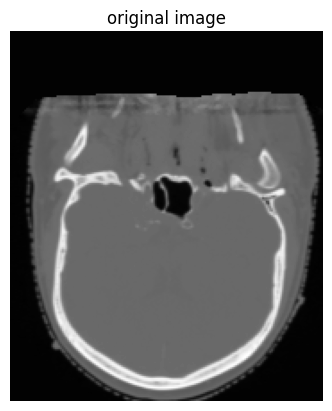

In [40]:
slice_number = 100
plt.imshow(sitk.GetArrayFromImage(image_sitk)[:,slice_number,:], cmap='gray')
plt.axis('off')
plt.title('original image')

Text(0.5, 1.0, 'original image')

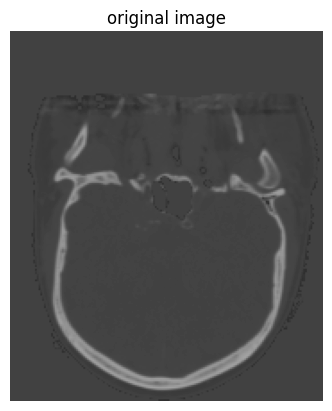

In [39]:
threshold = -300
binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=threshold, upperThreshold=3000)
connected_components = sitk.ConnectedComponent(binary_mask)
labeled_components = sitk.RelabelComponent(connected_components, sortByObjectSize=True)
skull_mask = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
skull_image = sitk.Mask(image_sitk, skull_mask)

slice_number = 100
plt.imshow(sitk.GetArrayFromImage(skull_image)[:,slice_number,:], cmap='gray', vmin=-1024, vmax=3000)
plt.axis('off')
plt.title('original image')

difference of connected component

Text(0.5, 1.0, 'non-largest component')

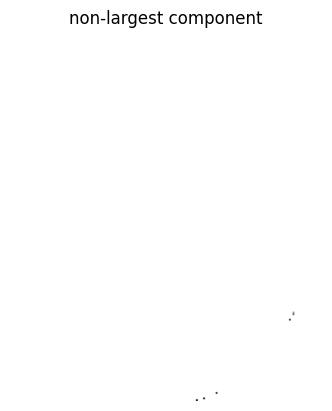

In [38]:
threshold = -150
binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=threshold, upperThreshold=3000)
connected_components = sitk.ConnectedComponent(binary_mask)
labeled_components = sitk.RelabelComponent(connected_components, sortByObjectSize=True)
skull_mask1 = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
skull_mask2 = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1000, insideValue=1, outsideValue=0)
img1 = sitk.GetArrayFromImage(sitk.Mask(image_sitk, skull_mask1))
img2 = sitk.GetArrayFromImage(sitk.Mask(image_sitk, skull_mask2))
diff = img2 - img1

slice_number = 100
plt.imshow(diff[:,slice_number,:], cmap='gray')
plt.axis('off')
plt.title('non-largest component')

Text(0.5, 1.0, 'non-largest component at threshold=400')

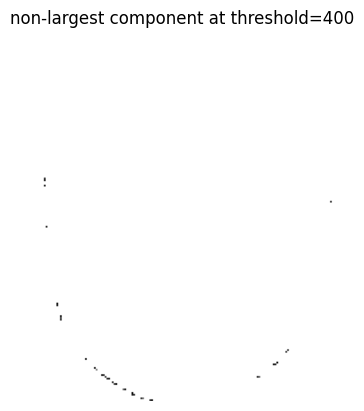

In [37]:
threshold = -400
binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=threshold, upperThreshold=3000)
connected_components = sitk.ConnectedComponent(binary_mask)
labeled_components = sitk.RelabelComponent(connected_components, sortByObjectSize=True)
skull_mask1 = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
skull_mask2 = sitk.BinaryThreshold(labeled_components, lowerThreshold=1, upperThreshold=1000, insideValue=1, outsideValue=0)
img1 = sitk.GetArrayFromImage(sitk.Mask(image_sitk, skull_mask1))
img2 = sitk.GetArrayFromImage(sitk.Mask(image_sitk, skull_mask2))
diff = img2 - img1

slice_number = 100
plt.imshow(diff[:,slice_number,:], cmap='gray')
plt.axis('off')
plt.title('non-largest component at threshold=400')

Text(0.5, 1.0, 'thresholding effect on the artifacts')

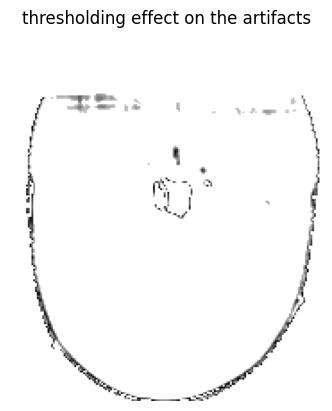

In [ ]:
binary_mask = sitk.BinaryThreshold(image_sitk, lowerThreshold=-700, upperThreshold=-150)
img = sitk.GetArrayFromImage(sitk.Mask(image_sitk, binary_mask))

slice_number = 100
plt.imshow(img[:,slice_number,:], cmap='gray')
plt.axis('off')
plt.title('thresholding effect on the artifacts')